In [2]:
using Revise

In [3]:
using Distributed
procs_to_use = 1

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples,
    ProgressMeter

@everywhere @consts begin
    λ = 626e-9
    Γ = 2π * 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [671]:
@everywhere begin

    # saturation intensity
    Isat = π*h*c*Γ/(3λ^3)/10
    
    # saturation parameter
    # P = 1.0 * 0.9 * 13.1 # 13 mW/1 V
    
    P = 0.3 * 13.1 # 13 mW/1 V # "equivalent" to 0.7 V with 750 kHz repump rate
    
    I = 2P / (π * 0.4^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = s * 3.7 / (3.7+2.8+3.5)
    s2 = s * 2.8 / (3.7+2.8+3.5)
    s3 = s * 3.5 / (3.7+2.8+3.5)
    
    detuning = 52 - (5.5 - (-0.5)) * 7.4
    # detuning = 8
    δ1 = 52.75 - 53.75
    δ2 = 52.75 - 52.00
    
    # δ1 = 52.75 - 55.00
    # δ2 = 52.75 - 53.50
    
    # δ1 = 52.75 - 53.50
    # δ2 = 52.75 - 51.75
    
    # can the detuning be flipped? think the following works if the B-field is also flipped
    # δ1 = 53.75 - 52.75
    # δ2 = 52.00 - 52.75
    
end
;

In [672]:
@everywhere sim_params = MutableNamedTuple(
    
    pol_imbalance = 0.0,
    s_imbalance = (0., 0., 0.),
    retro_loss = 0.,
    off_center = (0, 0, 0, 0, 0, 0) .* 1e-3,
    pointing_error = (0, 0, 0, 0, 0, 0),
    
    # pol_imbalance = 0.03,
    # s_imbalance = (0., 0., 0.),
    # retro_loss = 0.2,
    # off_center = (1, 1, 1, 1, 1, 1) .* 1e-3,
    # pointing_error = (0, 0, 0, 0, 0, 0),

    B_gradient = +72,
    B_ramp_time = 4e-3,
    B_offset = (0., 0., 0.),
    
    s_ramp_time = 4e-3,
    # s_ramp_to = 0.7/0.9,
    s_ramp_to = 1.0,

    s1 = s1,
    s2 = s2,
    s3 = s3,
    s4 = 0.0,
    Δ1 = detuning,
    Δ2 = detuning + δ1,
    Δ3 = detuning + δ2,
    Δ4 = 0.0,
    pol1_x = [1,0,0],
    pol2_x = [0,0,1],
    pol3_x = [1,0,0],
    pol4_x = [0,0,1]
    
#     # 2 frequencies
#     s_ramp_time = 4e-3,
#     s_ramp_to = 0.7/0.9,

#     s1 = s1 + s3/2,
#     s2 = s2 + s3/2,
#     s3 = 0.0,
#     s4 = 0.0,
#     Δ1 = detuning,
#     Δ2 = detuning + δ1,
#     Δ3 = detuning + δ2,
#     Δ4 = 0.0,
#     pol1_x = [1,0,0],
#     pol2_x = [0,0,1],
#     pol3_x = [1,0,0],
#     pol4_x = [0,0,1]

)
;

### Calculate transition dipole moments

In [673]:
@everywhere begin
    include("define_CaOH_states.jl")
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define lasers

In [674]:
@everywhere begin
    include("define_lasers.jl")
    # include("define_lasers_extra.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

### Define Zeeman Hamiltonian

In [675]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [676]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    # exponential ramp
    # τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    # scalar = (exp(t/τ_bfield) - 1) / (exp(1) - 1)
    # scalar = min(scalar, 1.0)
    
    gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [677]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat
)
;

In [678]:
@everywhere function solve_stochastic(prob, ts, save_every=100)
    p_diffusion, dψ, ψ, δt = prob
    
    save_length = ceil(Int, ts[end] / save_every)
    ψs = [Vector{ComplexF64}(undef, length(ψ)) for _ ∈ 1:save_length]
    saved = 0
    
    @showprogress for i ∈ eachindex(ts)

        t = ts[i]
        evolve_with_diffusion!(p_diffusion, dψ, ψ, δt, t)
        
        if (t - saved * save_every) > 0
            saved += 1
            ψs[saved] .= ψ
        end
            
    end

    return ψs
end
;

In [679]:
rand(Normal(0, p_diffusion.f_σ / p.mass))

0.00013831377391919776

In [931]:
function add_a_to_b(a, b, dt)
    @inbounds @fastmath for i ∈ eachindex(a)
        b[i] += a[i] * dt
    end
    return nothing
end
;

In [932]:
using BenchmarkTools
a = rand(ComplexF64, 1000)
b = rand(ComplexF64, 1000)
dt = 0.01
@btime add_a_to_b($a, $b, $dt)

  704.930 ns (0 allocations: 0 bytes)


In [917]:
@everywhere begin
    t_start = 0.0
    t_end   = 0.005e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0.5e-3) ./ (1/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0

end

δt = 1e-9 / (1/Γ)
ts = t_span[1]:δt:t_span[2]

p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

ψ = deepcopy(p.ψ)
dψ = deepcopy(p.ψ)

t0_idx = 1
ϕ = deepcopy(p.ψ)
dϕ = deepcopy(p.ψ)

# # schrodinger picture wavefunctions
# ψ_s = deepcopy(p.ψ)
# ϕ_s = deepcopy(p.ψ)

# fϕ_sum_t = 0.0
# ϕ_sum_t = deepcopy(p.ψ)
# fϕ_norm = 1.0

# p_diffusion = MutableNamedTuple(p=p, ϕ_sum_t=ϕ_sum_t, fϕ_sum_t=fϕ_sum_t, dϕ=dϕ, ϕ=ϕ, ψ_s=ψ_s, ϕ_s=ϕ_s, fϕ_norm=fϕ_norm, t0_idx=t0_idx, Δt=0.0, D=0.0+0im)

χ = deepcopy(p.ψ)

p_diffusion = MutableNamedTuple(p=p, χ=χ, f=0.0, f_σ=0.0)

prob = (p_diffusion, dψ, ψ, δt)

@time ψs = solve_stochastic(prob, ts);
p_diffusion.f_σ |> display 

0.0
0.0

-0.0001611498401617233
-0.00017675857279475147

-0.0003047959473779334
0.00034359622792215006

-0.00040931740382970684
0.0004874695733466826

-0.000461035113780542
0.0005957422592233944

-0.00045598015080248257
-0.000658015522323768

-0.00039909790455844123
-0.0006687826725932502

-0.00030171562474367274
0.0006296916408435775

-0.00017852934255492423
0.0005507409663775281

-4.517022914012434e-5
0.0004509621915324797

8.317919992124945e-5
-0.0003602841645168304

0.00019230793804951013
-0.0003189521341325349

0.00026926460213014594
-0.0003497208744121184

0.0003030949749177307
-0.0004307374673489981

0.0002864011920903533
-0.000534778121624678

0.00021751395511758793
-0.0006520221655658142

0.00010247207530639563
0.0007819809959068138

-4.430699416945897e-5
-0.000925092628663839

-0.00020154826552979573
-0.0010785823576274646

-0.00034493104053889075
-0.0012347361334290076

-0.00045228323160798246
-0.0013804328540789538

-0.0005085098445253203
0.0014981891906945541

-0.000508595

Progress:  24%|██████████                               |  ETA: 0:00:00



8.426584897260507e-5
-0.0002487429586556929

6.29717191792625e-5
-0.0002606551926514228

6.297798439297588e-5
-0.00025065294219183564

7.065237466577256e-5
0.00021677625097967377

7.113620902794692e-5
0.00016663117908557703

5.584696696817089e-5
0.00011817352364048485

2.689723304855383e-5
9.140525108809919e-5

-3.4933267269728214e-6
8.721023379770589e-5

-1.8363927297922768e-5
-9.290415744254834e-5

-3.853648521750545e-6
-0.0001070474134910237

4.387753044013189e-5
-0.00012331059287170118

0.00011568157109055024
-0.0001233159567090643

0.0001918110303236578
-8.872584501850984e-5

0.0002488703070405038
5.287923955708032e-5

0.000268634789216238
-8.607987169522349e-5

0.0002451576586688719
-2.920840450435165e-5

0.00018713435242103578
0.00011385947071498685

0.00011440227618679546
0.00016484633892249298

4.9995099909753354e-5
0.000198953748577717

1.1161257118622982e-5
0.0002263560870417303

3.1813555900601023e-6
0.0002442868492000235

1.8481213248750548e-5
-0.00024221167268740487

4.

Progress:  47%|████████████████████                     |  ETA: 0:00:00


-0.00021533391587375732

8.240797195527425e-5
-0.00017945688654147615

7.667983445703482e-5
-0.00013235702020575425

5.716429901220935e-5
-9.624297880570122e-5

2.8887446031874836e-5
-8.684933928705432e-5

4.708393263481778e-6
-9.01119892787949e-5

-4.727475008968677e-7
-9.18445749952502e-5

2.3223884587161764e-5
9.350603413734838e-5

7.540736887044576e-5
-9.091584367287719e-5

0.000144294900679745
6.285950515830287e-5

0.00021032989300768688
-7.150249484000583e-5

0.0002532147086345553
0.00011919183444894648

0.0002595996632823177
-0.00012904757575965631

0.00022828624065917444
0.0001028437314200637

0.00017069018223567965
-1.5550019366559787e-5

0.00010624732062983949
0.00010956121929477342

5.4656685105434176e-5
-0.00015578006731401707

2.828866121367808e-5
-0.00019078628005085284

2.7993569952374363e-5
0.00020914648074303068

4.396991353653563e-5
-0.00020248195276085333

6.1100401377045e-5
0.00017066412619119536

6.627435376186642e-5
-0.000125927141802412

5.446267610135648e-5
9.1

Progress:  75%|███████████████████████████████          |  ETA: 0:00:00


-0.00013898385546714517

-2.1881465401119e-5
0.00012801873268589677

-2.1286817030387592e-6
0.00011090876795675846

1.0668422033866569e-5
9.98095774193856e-5

1.6229059664397128e-5
-0.00010371853510464024

1.678669288637323e-5
0.00011778391185754961

1.5621293032472763e-5
0.00013242542956676427

1.5231091924138193e-5
0.00014361370356223027

1.5983552372148055e-5
-0.00015223364816759107

1.586211366120637e-5
0.000160281761557316

1.1447128459853551e-5
-0.0001677022076607136

-2.747492528413256e-7
0.00017154961438988408

-2.0075621452680173e-5
-0.00016754943554915468

-4.549518727435274e-5
0.000152695040452437

-7.123383504217214e-5
-0.00012788309029008877

-9.085651647920763e-5
-0.00010048721416795337

-9.914054398337225e-5
-8.524698816216512e-5

-9.408124427164566e-5
-9.06786919806797e-5

-7.771089027751867e-5
-0.00010310852909374218

-5.536093715313612e-5
-0.00010727952584618477

-3.36417759427806e-5
-9.892661818061903e-5

-1.7949569267536285e-5
8.378349910671923e-5

-1.0534776916062

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00



-0.00017789051537595265

-0.00012742067628789894
-0.00019921513785822856

-0.00011267360425362311
-0.00021964819013438943

-9.0031487546759e-5
-0.0002333387464006436

-6.555878119455801e-5
0.0002386478708252043

-4.35247003615181e-5
-0.00023695670195917536

-2.5265456711599227e-5
-0.00023039891896547076

-9.463179043734624e-6
0.00022026371130075216

6.347110632087947e-6
0.00020686036808633204

2.3758379665499304e-5
-0.00019038218240368136

4.191115078844812e-5
0.00017199617397609918

5.7125914591435835e-5
0.0001548818399851061

6.39950468145994e-5
0.00014430058425294375

5.752459220960429e-5
0.00014415207151456075

3.5422248796992286e-5
-0.00015161290069751535

-4.4840083658281693e-7
0.00015853044513301052

-4.409170053248704e-5
0.00015849735393310584

-8.692523318305625e-5
0.00015185678638385654

-0.00012030346191842547
-0.00014678519327469158

-0.00013810538477833823
-0.0001537264953653718

-0.00013845884019747927
0.00017378827556729562

-0.0001239829789956704
-0.0001979393023475599

0.11051271119104694

In [833]:
dp = sample_direction(1)
dv = dp ./ p.mass

(-4.892330923462061e-5, 0.0013550694522272081, 0.0024398029591333158)

In [834]:
prob[1].p.n_scatters / t_end

1.0675e6

In [835]:
x(ψ) = real(ψ[21]) * (1/k) * 1e3
y(ψ) = real(ψ[22]) * (1/k) * 1e3
z(ψ) = real(ψ[23]) * (1/k) * 1e3
vx(ψ) = real(ψ[24]) * (Γ/k)
vy(ψ) = real(ψ[25]) * (Γ/k)
vz(ψ) = real(ψ[26]) * (Γ/k)
;

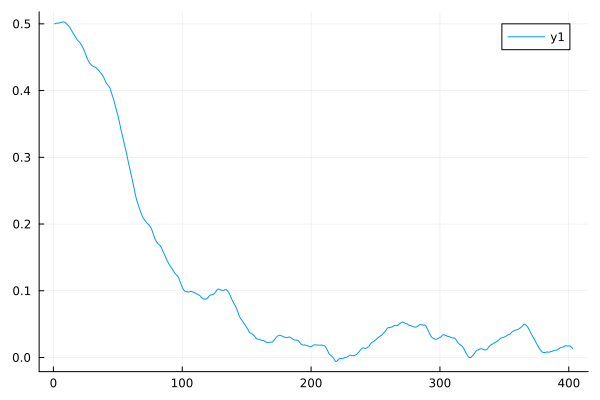

In [836]:
plot( z.(ψs[1:10:end]) )

In [837]:
T_1D(v) = m*v^2 / kB
T_3D(v) = m*v^2 / (3kB)
;

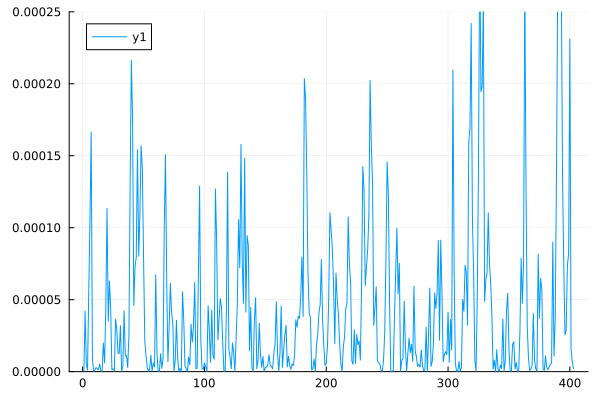

In [838]:
plot( T_1D.(vx.(ψs[1:10:end])) , ylim=(0, 0.00025))

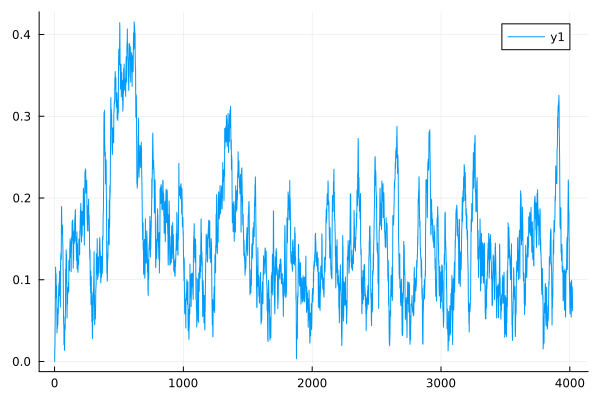

In [839]:
plot(v.(ψs))

In [842]:
v(ψ) = sqrt(vx(ψ)^2 + vy(ψ)^2 + vz(ψ)^2)
vs = sqrt( mean(v.(ψs[rms_indices]).^2) )
T_3D(vs) * 1e6

44.697610756852065

In [904]:
vs = vx
rms_indices = floor(Int, length(ψs)/2):length(ψs)
v_rms = sqrt( mean(vs.(ψs[rms_indices]).^2) )
T_1D(v_rms) * 1e6 |> display

vs = vy
rms_indices = floor(Int, length(ψs)/2):length(ψs)
v_rms = sqrt( mean(vs.(ψs[rms_indices]).^2) )
T_1D(v_rms) * 1e6 |> display

vs = vz
rms_indices = floor(Int, length(ψs)/2):length(ψs)
v_rms = sqrt( mean(vs.(ψs[rms_indices]).^2) )
T_1D(v_rms) * 1e6 |> display

45.16598250710671

56.79919847166647

53.33844936560471

In [899]:
vs = [v.(ψ) for ψ ∈ sols]
;

In [900]:
vs_ = [[v[end-2] for v ∈ vs]; [v[end-1] for v ∈ vs]; [v[end] for v ∈ vs]]
;

2-element Vector{Float64}:
 0.9924397146144205
 5.222506656583735e-5

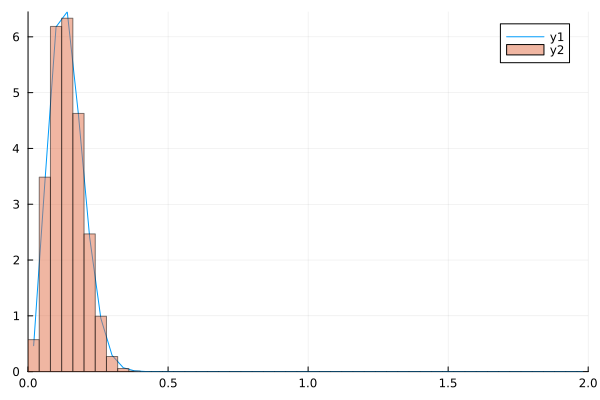

In [903]:
using LsqFit

vs = [v.(ψ) for ψ ∈ sols]

function maxwell_boltzmann(v, p)
    A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v_[i] for v_ ∈ vs] for i ∈ 3000:4000]
vs = vec(hcat(vs...))

hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
hist_data.isdensity = true
v_ = collect(hist_data.edges[1])
dv = v_[2]-v_[1]
v_ = v_[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v_, fv, [4, 100e-6])
A, T = v_fit.param

display(v_fit.param)
plot(v_, maxwell_boltzmann(v_, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 2.0), alpha=0.5, normalize=true)

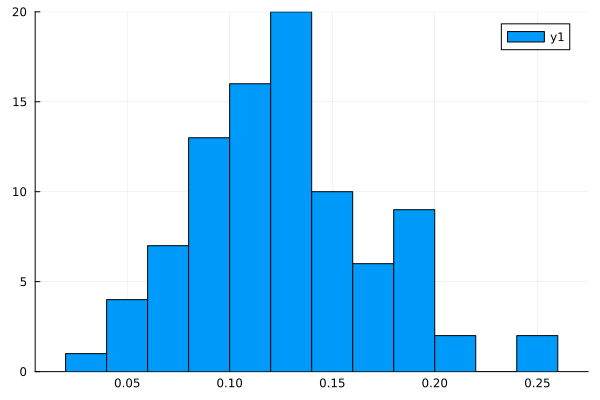

In [877]:
histogram([v[end] for v ∈ vs_], bins=10)

### Run simulation for multiple particles in parallel

In [842]:
@everywhere function prob_func(prob, i, repeat)
    
    sim_params = prob.p.sim_params
    
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    # Define initial conditions for the molecule
    cloud_size = @with_unit 0.5 "mm"
    particle = Particle()
    particle.r = (rand(Normal(0e-3, cloud_size)), rand(Normal(0e-3, cloud_size)), rand(Normal(0e-3, cloud_size))) ./ (1/k)

    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0

    # p = schrodinger_stochastic_repump(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H, dark_lifetime=dark_lifetime, FC_mainline=0.9459)
    # callback = ContinuousCallback(condition_repump, SE_collapse_repump!, nothing, save_positions=(false,false))
    # prob = ODEProblem(ψ_stochastic_repump!, p.ψ, t_span, p, callback=callback, reltol=5e-4, saveat=1000, maxiters=80000000)

    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    callback = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p, callback=callback, reltol=1e-3, saveat=1000, maxiters=80000000)
    
    return prob
end
;

In [843]:
@everywhere times = 1:floor(t_span[2] / 1000)
;

In [844]:
n_molecules = 60

ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, Tsit5(), EnsembleDistributed(); trajectories=n_molecules)
;

 68.494595 seconds (1.35 M allocations: 55.883 MiB)


In [845]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
photons_scattered = zeros(n_molecules)

excited_populations = Array{Vector{Float64}}(fill([],n_molecules))

times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]
    
    x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
    y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
    z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
    
    photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters
    
    excited_population = real.([sum(conj(u[i]) * u[i] for i ∈ 13:16) for u in sol_u])
    
    excited_populations[i] = excited_population
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i], y_trajectories[i], z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

In [862]:
function survived(i, t_end, times)
    return t_end ≈ times[i][end]
end

survived_molecules = [i for i ∈ 1:n_molecules if survived(i, t_end, times)]

survived_times = times[survived_molecules]

survived_x_trajectories = x_trajectories[survived_molecules]
survived_y_trajectories = y_trajectories[survived_molecules]
survived_z_trajectories = z_trajectories[survived_molecules]

survived_x_velocities = x_velocities[survived_molecules]
survived_y_velocities = y_velocities[survived_molecules]
survived_z_velocities = z_velocities[survived_molecules]
;

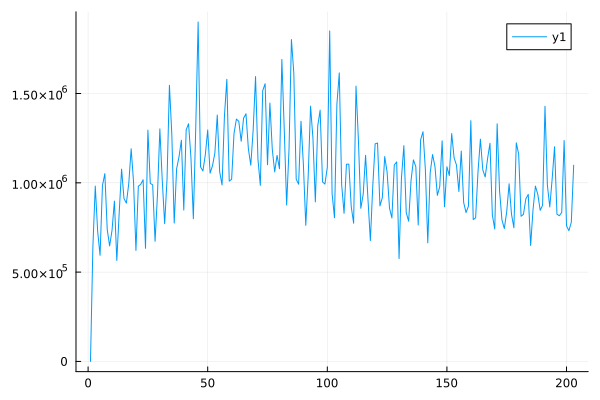

In [863]:
Γ .* mean(excited_populations[i] for i ∈ survived_molecules) |> plot

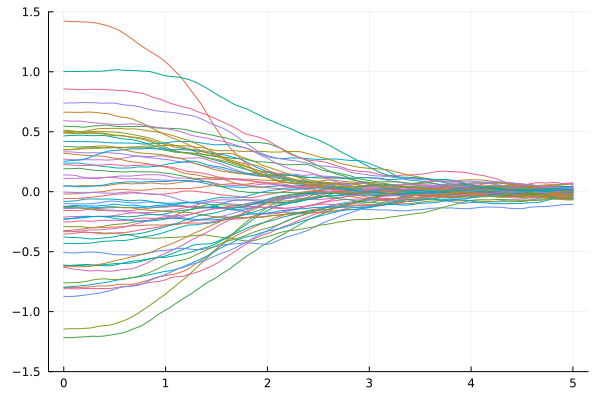

In [864]:
lim = 1.5
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, z_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()

In [865]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.8:0.02:0.8)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.5, 0., 5])
    σ, x0, A = v_fit.param
    
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

3-element Vector{Float64}:
  0.03250127560080022
  0.004439458289085396
 11.799660115926809

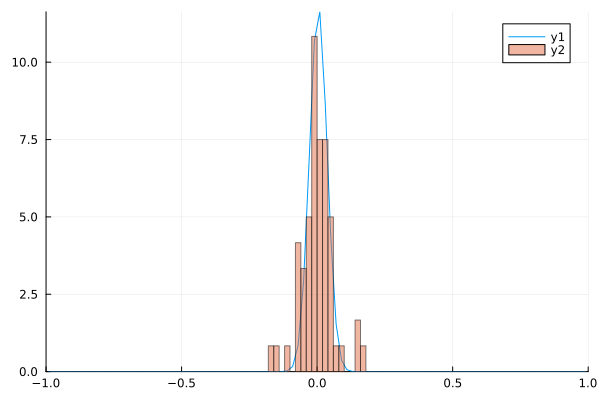

In [867]:
xs = [x_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
ys = [y_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
zs = [z_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]

hist_data = fit(Histogram, zs, -1.0:0.02:1.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(ys, bins=hist_data.edges, xlim=(-1.0, 1.0), alpha=0.5, normalize=true)

In [868]:
plot_ts = 0:0.1e-3:4.9e-3
cloud_sizes = [cloud_size(t, 
        times[survived_molecules], 
        x_trajectories[survived_molecules],
        y_trajectories[survived_molecules],
        z_trajectories[survived_molecules])
    for t ∈ plot_ts]
;

In [869]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(x_trajectories[survived_molecules][1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(y_trajectories[survived_molecules][1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(z_trajectories[survived_molecules][1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

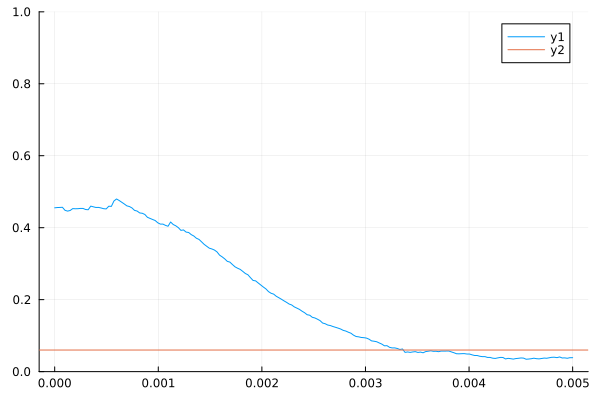

In [853]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,1.0))
hline!([0.06])

In [854]:
cloud_sizes_fitted

203-element Vector{Float64}:
 0.45520195203930275
 0.45601101059070875
 0.4562684357314105
 0.45672474180573036
 0.4483224618603934
 0.44610882456214707
 0.4478039496255185
 0.45299177081207304
 0.4526339144448584
 0.45279047776421727
 0.4536142031404851
 0.453500395567019
 0.45054387621687536
 ⋮
 0.037144644803297766
 0.0385121535538435
 0.03983843458066753
 0.03991752030203143
 0.03885255064756049
 0.04076998190840323
 0.03793251564849076
 0.0381545842584659
 0.03711571955114795
 0.038730413571298174
 0.03868165001764375
 0.03868165001764375

2-element Vector{Float64}:
 0.8451499238369163
 4.84693531721441e-5

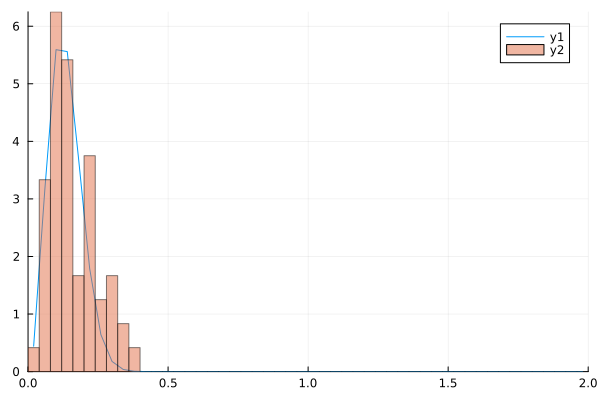

In [855]:
velocities = [sqrt.(x_velocities[i].^2 .+ y_velocities[i].^2 .+ z_velocities[i].^2) for i ∈ survived_molecules];

function maxwell_boltzmann(v, p)
    A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v[i] for v ∈ velocities] for i ∈ 203:203]
vs = vec(hcat(vs...))

hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
A, T = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 2.0), alpha=0.5, normalize=true)

In [859]:
T * 1e6

48.469353172144096

In [860]:
function fit_temperature(vs)

    hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
    A, T = v_fit.param
    
    # histogram!(vs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return T
end
;

In [861]:
fit_temperature([v[end] for v ∈ velocities]) * 1e6

48.469353172144096

### Scan intensity

In [197]:
function update_function_intensity(sim_params, intensity)
    
    # saturation intensity
    Isat = π*h*c*Γ/(3λ^3)/10
    
    # saturation parameter
    P = intensity * 13.1 # 13 mW/1 V
    I = 2P / (π * 0.4^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = s * 3.7 / (3.7+2.8+3.5)
    s2 = s * 2.8 / (3.7+2.8+3.5)
    s3 = s * 3.5 / (3.7+2.8+3.5)
    
    sim_params.s1 = s1
    sim_params.s2 = s2
    sim_params.s3 = s3
    
    return nothing
end
;

In [198]:
intensities = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1] .* (0.25/0.7)

n_molecules = 40

sols = []
for intensity ∈ intensities

    update_function_intensity(prob.p.sim_params, intensity)
    
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    @time ensemble_sol = solve(ensemble_prob, Tsit5(), EnsembleDistributed(); trajectories=n_molecules)
    
    push!(sols, ensemble_sol)
end
;

 58.354290 seconds (980.90 k allocations: 39.776 MiB, 0.03% gc time)
 69.337222 seconds (982.08 k allocations: 39.846 MiB, 0.04% gc time)
 71.448136 seconds (982.32 k allocations: 39.860 MiB, 0.04% gc time)
 75.639169 seconds (982.20 k allocations: 39.849 MiB, 0.02% gc time)
 78.970403 seconds (982.25 k allocations: 39.850 MiB, 0.02% gc time)
 84.053643 seconds (982.41 k allocations: 39.853 MiB, 0.02% gc time)
 83.026523 seconds (981.93 k allocations: 39.837 MiB, 0.02% gc time)
 86.900456 seconds (981.87 k allocations: 39.803 MiB)
 92.998672 seconds (982.93 k allocations: 39.886 MiB, 0.02% gc time)
102.771731 seconds (982.92 k allocations: 39.868 MiB, 0.02% gc time)


In [202]:
# analyze each solution across all intensities
σs = []
Ts = []

for sol ∈ sols

    times = [sol[i].t for i ∈ 1:n_molecules] .* (1/Γ)

    survived_i = [i for i ∈ 1:n_molecules if t_end ≈ times[i][end]]

    xs = [real(sol[i].u[end][n_states + n_excited + 1]) for i ∈ survived_i] ./ k*1e3
    ys = [real(sol[i].u[end][n_states + n_excited + 2]) for i ∈ survived_i] ./ k*1e3
    zs = [real(sol[i].u[end][n_states + n_excited + 3]) for i ∈ survived_i] ./ k*1e3

    v_xs = [real(sol[i].u[end][n_states + n_excited + 4]) for i ∈ survived_i] ./ (k/Γ)
    v_ys = [real(sol[i].u[end][n_states + n_excited + 5]) for i ∈ survived_i] ./ (k/Γ)
    v_zs = [real(sol[i].u[end][n_states + n_excited + 6]) for i ∈ survived_i] ./ (k/Γ)
    
    vs = sqrt.(v_xs.^2 .+ v_ys.^2 .+ v_zs.^2)
    
    push!(σs, (cloud_size_fitted(xs) * cloud_size_fitted(ys) * cloud_size_fitted(zs))^(1/3))
    push!(Ts, fit_temperature(vs))
    
end
;

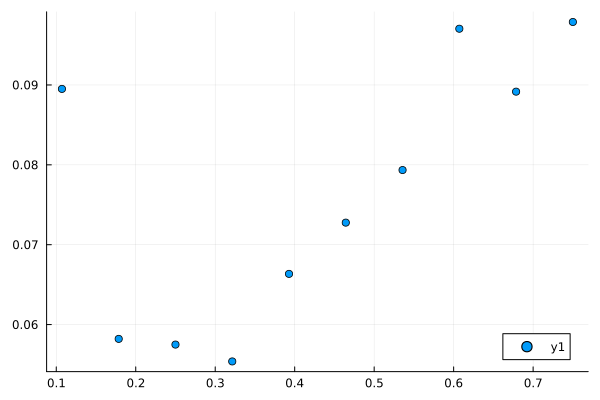

In [203]:
scatter(intensities, σs)

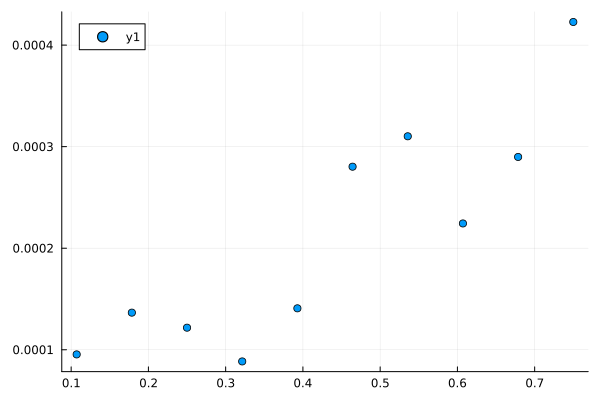

In [204]:
scatter(intensities, Ts)

### Scan detuning

In [38]:
function update_function_detuning(sim_params, detuning)
    
    # saturation intensity
    Isat = π*h*c*Γ/(3λ^3)/10
    
    # saturation parameter
    P = 0.25 * 13.1 # 13 mW/1 V
    I = 2P / (π * 0.4^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = s * 3.7 / (3.7+2.8+3.5)
    s2 = s * 2.8 / (3.7+2.8+3.5)
    s3 = s * 3.5 / (3.7+2.8+3.5)
    
    sim_params.s1 = s1
    sim_params.s2 = s2
    sim_params.s3 = s3
    
    # set detuning
    δ1 = 52.75 - 53.75
    δ2 = 52.75 - 52.00
    sim_params.Δ1 = detuning
    sim_params.Δ2 = detuning + δ1
    sim_params.Δ3 = detuning + δ2
    
    return nothing
end
;

In [50]:
detunings = [1, 4, 9, 13, 16]

n_molecules = 100

detuning_sols = []
for detuning ∈ detunings

    update_function_detuning(prob.p.sim_params, detuning)
    
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    @time ensemble_sol = solve(ensemble_prob, Tsit5(), EnsembleDistributed(); trajectories=n_molecules)
    
    push!(detuning_sols, ensemble_sol)
end
;

191.920547 seconds (2.10 M allocations: 88.877 MiB, 0.03% gc time, 0.00% compilation time)
171.904563 seconds (2.10 M allocations: 88.747 MiB, 0.03% gc time)
148.221511 seconds (2.10 M allocations: 88.862 MiB, 0.03% gc time)
154.578098 seconds (2.10 M allocations: 88.733 MiB, 0.02% gc time)
161.773392 seconds (2.10 M allocations: 88.738 MiB, 0.02% gc time)


In [54]:
# analyze each solution across all intensities
σs = []
Ts = []

for sol ∈ detuning_sols[2:end]

    times = [sol[i].t for i ∈ 1:n_molecules] .* (1/Γ)

    survived_i = [i for i ∈ 1:n_molecules if t_end ≈ times[i][end]]

    xs = [real(sol[i].u[end][n_states + n_excited + 1]) for i ∈ survived_i] ./ k*1e3
    ys = [real(sol[i].u[end][n_states + n_excited + 2]) for i ∈ survived_i] ./ k*1e3
    zs = [real(sol[i].u[end][n_states + n_excited + 3]) for i ∈ survived_i] ./ k*1e3

    v_xs = [real(sol[i].u[end][n_states + n_excited + 4]) for i ∈ survived_i] ./ (k/Γ)
    v_ys = [real(sol[i].u[end][n_states + n_excited + 5]) for i ∈ survived_i] ./ (k/Γ)
    v_zs = [real(sol[i].u[end][n_states + n_excited + 6]) for i ∈ survived_i] ./ (k/Γ)
    
    vs = sqrt.(v_xs.^2 .+ v_ys.^2 .+ v_zs.^2)
    
    push!(σs, (cloud_size_fitted(xs) * cloud_size_fitted(ys) * cloud_size_fitted(zs))^(1/3))
    push!(Ts, fit_temperature(vs))
    
end
;

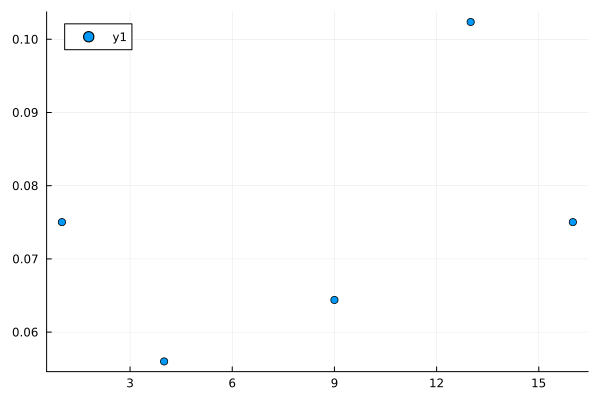

In [55]:
scatter(detunings, σs)

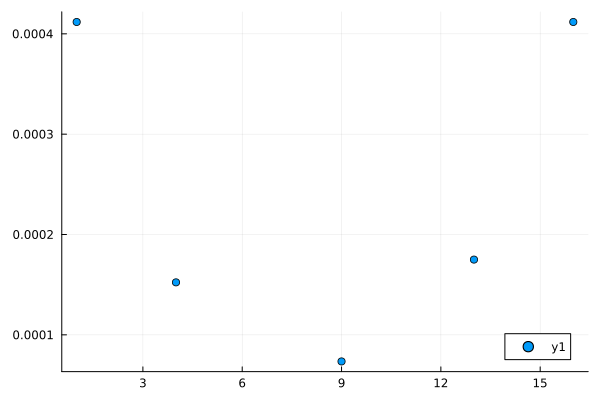

In [56]:
scatter(detunings, Ts)